In [1]:
#! /usr/bin/python3

__author__ = "Jun Hu <jh3846@columbia.edu"
__date__ = "Apr 10, 2018"

import logging

logger = logging.getLogger('etl')
logger.setLevel(logging.DEBUG)

ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

formatter_c = logging.Formatter('[%(asctime)s]-[%(process)d]-[%(thread)d]-[%(name)s]-[%(lineno)s]-[%(levelname)s]: %(message)s')
ch.setFormatter(formatter_c)

logger.addHandler(ch)

import pandas as pd
import time

from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np

from keras.models import Sequential
import keras.backend as K
from keras.layers import Dense
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
df1 = pd.read_pickle(r"F:\courses\bcr_data\d1.pickle")
df2 = pd.read_pickle(r"F:\courses\bcr_data\d2.pickle")
df3 = pd.read_pickle(r"F:\courses\bcr_data\d3.pickle")
df4 = pd.read_pickle(r"F:\courses\bcr_data\d4.pickle")
df5 = pd.read_pickle(r"F:\courses\bcr_data\d5.pickle")

In [4]:
df = pd.concat([df1, df2, df3, df4, df5], axis=1)
logger.debug(df.shape)
df.head()

[2018-04-24 19:50:20,593]-[5244]-[8988]-[etl]-[2]-[DEBUG]: (4241, 17)


,cancer,unigram,bigram,trigram,four_gram,five_gram,six_gram,trigram_skip2,trigram_skip3,unigram_cls,bigram_cls,trigram_cls,four_gram_cls,five_gram_cls,six_gram_cls,trigram_cls_skip2,trigram_cls_skip3
0,THCA,D Y W G Q G R S D D T A V Y F C G D S P P F F ...,DY YW WG GQ QG RS SD DD DT TA AV VY YF FC GD D...,DYW YWG WGQ GQG RSD SDD DDT DTA TAV AVY VYF YF...,DYWG YWGQ WGQG RSDD SDDT DDTA DTAV TAVY AVYF V...,DYWGQ YWGQG RSDDT SDDTA DDTAV DTAVY TAVYF AVYF...,DYWGQG RSDDTA SDDTAV DDTAVY DTAVYF TAVYFC GDSP...,DWQ YGG RDT SDA DTV DAY TVF AYC GSP DPF SPF PF...,RTF SAC GPY DFW SFG PDQ PYG RTF SAC DVA DYR TF...,4 Y W G 5 G 6 3 4 4 3 1 1 Y F 2 G 4 3 P P F F ...,4Y YW WG G5 5G 63 34 44 43 31 11 1Y YF F2 G4 4...,4YW YWG WG5 G5G 634 344 443 431 311 11Y 1YF YF...,4YWG YWG5 WG5G 6344 3443 4431 4311 311Y 11YF 1...,4YWG5 YWG5G 63443 34431 44311 4311Y 311YF 11YF...,4YWG5G 634431 344311 44311Y 4311YF 311YF2 G43P...,4W5 YGG 643 341 431 41Y 31F 1Y2 G3P 4PF 3PF PF...,63F 312 GPY 4FW 3FG P45 PYG 63F 312 411 4Y6 3F...
1,LUSC,Y Y C A R G V V Y Y C A R V G Y Y Y D S S D Y ...,YY YC CA AR RG GV VV YY YC CA AR RV VG GY YY Y...,YYC YCA CAR ARG RGV GVV YYC YCA CAR ARV RVG VG...,YYCA YCAR CARG ARGV RGVV YYCA YCAR CARV ARVG R...,YYCAR YCARG CARGV ARGVV YYCAR YCARV CARVG ARVG...,YYCARG YCARGV CARGVV YYCARV YCARVG CARVGY ARVG...,YCR YAG CRV AGV YCR YAV CRG AVY RGY VYY GYD YY...,YRY YVY CGD AYS RYS VYD GDY YSP YSM YSL CLR AW...,Y Y 2 1 6 G 1 1 Y Y 2 1 6 1 G Y Y Y 4 3 3 4 Y ...,YY Y2 21 16 6G G1 11 YY Y2 21 16 61 1G GY YY Y...,YY2 Y21 216 16G 6G1 G11 YY2 Y21 216 161 61G 1G...,YY21 Y216 216G 16G1 6G11 YY21 Y216 2161 161G 6...,YY216 Y216G 216G1 16G11 YY216 Y2161 2161G 161G...,YY216G Y216G1 216G11 YY2161 Y2161G 2161GY 161G...,Y26 Y1G 261 1G1 Y26 Y11 26G 11Y 6GY 1YY GY4 YY...,Y6Y Y1Y 2G4 1Y3 6Y3 1Y4 G4Y Y3P Y32 Y31 216 1W...
2,OV,R E H S S S S W Y F D Y W G Q G Y Y C A R H E ...,RE EH HS SS SS SS SW WY YF FD DY YW WG GQ QG Y...,REH EHS HSS SSS SSS SSW SWY WYF YFD FDY DYW YW...,REHS EHSS HSSS SSSS SSSW SSWY SWYF WYFD YFDY F...,REHSS EHSSS HSSSS SSSSW SSSWY SSWYF SWYFD WYFD...,REHSSS EHSSSS HSSSSW SSSSWY SSSWYF SSWYFD SWYF...,RHS ESS HSS SSW SSY SWF SYD WFY YDW FYG DWQ YG...,RSY ESF HSD SWY SYW SFG SDQ WYG YRG YHQ CES AD...,6 4 6 3 3 3 3 W Y F 4 Y W G 5 G Y Y 2 1 6 6 4 ...,64 46 63 33 33 33 3W WY YF F4 4Y YW WG G5 5G Y...,646 463 633 333 333 33W 3WY WYF YF4 F4Y 4YW YW...,6463 4633 6333 3333 333W 33WY 3WYF WYF4 YF4Y F...,64633 46333 63333 3333W 333WY 33WYF 3WYF4 WYF4...,646333 463333 63333W 3333WY 333WYF 33WYF4 3WYF...,663 433 633 33W 33Y 3WF 3Y4 WFY Y4W FYG 4W5 YG...,63Y 43F 634 3WY 3YW 3FG 345 WYG Y6G Y65 243 14...
3,COAD,D Y Y F D Y W G Q G Y Y C A R E P N G P A Y Y ...,DY YY YF FD DY YW WG GQ QG YY YC CA AR RE EP P...,DYY YYF YFD FDY DYW YWG WGQ GQG YYC YCA CAR AR...,DYYF YYFD YFDY FDYW DYWG YWGQ WGQG YYCA YCAR C...,DYYFD YYFDY YFDYW FDYWG DYWGQ YWGQG YYCAR YCAR...,DYYFDY YYFDYW YFDYWG FDYWGQ DYWGQG YYCARE YCAR...,DYD YFY YDW FYG DWQ YGG YCR YAE CRP AEN RPG EN...,DDQ YYG YRG YEP AYV YGW YMG YDQ YVG DYK TYE AY...,4 Y Y F 4 Y W G 5 G Y Y 2 1 6 4 P 5 G P 1 Y Y ...,4Y YY YF F4 4Y YW WG G5 5G YY Y2 21 16 64 4P P...,4YY YYF YF4 F4Y 4YW YWG WG5 G5G YY2 Y21 216 16...,4YYF YYF4 YF4Y F4YW 4YWG YWG5 WG5G YY21 Y216 2...,4YYF4 YYF4Y YF4YW F4YWG 4YWG5 YWG5G YY216 Y216...,4YYF4Y YYF4YW YF4YWG F4YWG5 4YWG5G YY2164 Y216...,4Y4 YFY Y4W FYG 4W5 YGG Y26 Y14 26P 145 6PG 45...,445 YYG Y6G Y4P 1Y1 YGW Y2G Y45 Y1G 4Y6 3Y4 1Y...
4,THCA,Y S S G S T L D Y W G Q G Y Y Y G M D V W G Q ...,YS SS SG GS ST TL LD DY YW WG GQ QG YY YY YG G...,YSS SSG SGS GST STL TLD LDY DYW YWG WGQ GQG YY...,YSSG SSGS SGST GSTL STLD TLDY LDYW DYWG YWGQ W...,YSSGS SSGST SGSTL GSTLD STLDY TLDYW LDYWG DYWG...,YSSGST SSGSTL SGSTLD GSTLDY STLDYW TLDYWG LDYW...,YSS SGT SSL GTD SLY TDW LYG DWQ YGG YYM YGD YM...,YSY STW SLG GDQ SYG YMG YDQ YVG EYV TGW NMG YD...,Y 3 3 G 3 3 1 4 Y W G 5 G Y Y Y G 2 4 1 W G 5 ...,Y3 33 3G G3 33 31 14 4Y YW WG G5 5G YY YY YG G...,Y33 33G 3G3 G33 331 314 14Y 4YW YWG WG5 G5G YY...,Y33G 33G3 3G33 G3

In [56]:
# start_time = time.time()
# 
# df_vec1000 = df.copy()
# max_features = 1000
# 
# # ou can change the token_pattern parameter from (?u)\\b\\w\\w+\\b (default) to (?u)\\b\\w\\w*\\b; The default matches token that has two or more word characters (in case you are not familiar with regex, + means one or more, so \\w\\w+ matches word with two or more word characters; * on the other hand means zero or more, \\w\\w* will thus match word with one or more characters):
# tfidf = TfidfVectorizer(max_features=max_features, stop_words=None, lowercase=False, token_pattern='(?u)\\b\\w\\w*\\b')
# 
# for i in range(1, 17):
#     start_time1 = time.time()
#     df_vec1000.iloc[:, i] = tfidf.fit_transform(df_vec1000.iloc[:, i]).toarray().tolist()
#     logger.debug("--- %s seconds ---" % (time.time() - start_time1))
# logger.debug("--- %s seconds ---" % (time.time() - start_time))
# df_vec1000.to_pickle("/Volumes/PORT_exFAT/courses/bcr_data/df_vec1000.pickle")



[2018-04-24 17:32:34,796]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 80.86641097068787 seconds ---


[2018-04-24 17:32:34,796]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 80.86641097068787 seconds ---


[2018-04-24 17:34:01,559]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 86.76229095458984 seconds ---


[2018-04-24 17:34:01,559]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 86.76229095458984 seconds ---


[2018-04-24 17:35:34,378]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 92.8165488243103 seconds ---


[2018-04-24 17:35:34,378]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 92.8165488243103 seconds ---


[2018-04-24 17:37:13,820]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 99.43568730354309 seconds ---


[2018-04-24 17:37:13,820]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 99.43568730354309 seconds ---


[2018-04-24 17:39:06,972]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 113.1470639705658 seconds ---


[2018-04-24 17:39:06,972]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 113.1470639705658 seconds ---


[2018-04-24 17:41:58,275]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 171.3006227016449 seconds ---


[2018-04-24 17:41:58,275]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 171.3006227016449 seconds ---


[2018-04-24 17:43:21,869]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 83.58299684524536 seconds ---


[2018-04-24 17:43:21,869]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 83.58299684524536 seconds ---


[2018-04-24 17:44:07,806]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 45.931172132492065 seconds ---


[2018-04-24 17:44:07,806]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 45.931172132492065 seconds ---


[2018-04-24 17:45:29,110]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 81.30311894416809 seconds ---


[2018-04-24 17:45:29,110]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 81.30311894416809 seconds ---


[2018-04-24 17:47:03,497]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 94.38426280021667 seconds ---


[2018-04-24 17:47:03,497]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 94.38426280021667 seconds ---


[2018-04-24 17:48:32,719]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 89.22001194953918 seconds ---


[2018-04-24 17:48:32,719]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 89.22001194953918 seconds ---


[2018-04-24 17:50:09,805]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 97.08258605003357 seconds ---


[2018-04-24 17:50:09,805]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 97.08258605003357 seconds ---


[2018-04-24 17:51:57,058]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 107.24352478981018 seconds ---


[2018-04-24 17:51:57,058]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 107.24352478981018 seconds ---


[2018-04-24 17:53:41,177]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 104.10804724693298 seconds ---


[2018-04-24 17:53:41,177]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 104.10804724693298 seconds ---


[2018-04-24 17:54:56,507]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 75.32597136497498 seconds ---


[2018-04-24 17:54:56,507]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 75.32597136497498 seconds ---


[2018-04-24 17:55:46,850]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 50.34110999107361 seconds ---


[2018-04-24 17:55:46,850]-[11397]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 50.34110999107361 seconds ---


[2018-04-24 17:55:46,860]-[11397]-[140735658623872]-[etl]-[13]-[DEBUG]: --- 1472.9488430023193 seconds ---


[2018-04-24 17:55:46,860]-[11397]-[140735658623872]-[etl]-[13]-[DEBUG]: --- 1472.9488430023193 seconds ---


In [5]:
# start_time = time.time()
# 
# df_vec10000 = df.copy()
# max_features = 10000
# 
# # ou can change the token_pattern parameter from (?u)\\b\\w\\w+\\b (default) to (?u)\\b\\w\\w*\\b; The default matches token that has two or more word characters (in case you are not familiar with regex, + means one or more, so \\w\\w+ matches word with two or more word characters; * on the other hand means zero or more, \\w\\w* will thus match word with one or more characters):
# tfidf = TfidfVectorizer(max_features=max_features, stop_words=None, lowercase=False, token_pattern='(?u)\\b\\w\\w*\\b')
# 
# for i in range(1, 17):
#     start_time1 = time.time()
#     df_vec10000.iloc[:, i] = tfidf.fit_transform(df_vec10000.iloc[:, i]).toarray().tolist()
#     logger.debug("--- %s seconds ---" % (time.time() - start_time1))
# logger.debug("--- %s seconds ---" % (time.time() - start_time))
# 
# df_vec10000.to_pickle(r"F:\courses\bcr_data\df_vec10000.pickle")

[2018-04-24 19:54:01,722]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 75.05780625343323 seconds ---


[2018-04-24 19:55:24,654]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 82.93081402778625 seconds ---


[2018-04-24 19:56:46,521]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 81.864905834198 seconds ---


[2018-04-24 19:58:21,999]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 95.47649383544922 seconds ---


[2018-04-24 20:05:33,854]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 431.85456562042236 seconds ---


[2018-04-24 20:15:45,171]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 611.3135178089142 seconds ---


[2018-04-24 20:19:55,574]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 250.4016752243042 seconds ---


[2018-04-24 20:21:05,720]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 70.14262890815735 seconds ---


[2018-04-24 21:02:35,201]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 2489.479713201523 seconds ---


[2018-04-24 21:07:49,722]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 314.5038962364197 seconds ---


[2018-04-24 21:12:28,719]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 278.69273853302 seconds ---


[2018-04-24 21:15:17,014]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 168.2946493625641 seconds ---


[2018-04-24 21:19:15,221]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 238.20289039611816 seconds ---


[2018-04-24 21:22:05,068]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 169.8456814289093 seconds ---


[2018-04-24 21:26:50,152]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 285.0818667411804 seconds ---


[2018-04-24 21:27:51,585]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 61.430301904678345 seconds ---


[2018-04-24 21:27:51,591]-[5244]-[8988]-[etl]-[13]-[DEBUG]: --- 5704.9492337703705 seconds ---


In [16]:
start_time = time.time()

df_vec100 = df.copy()
max_features = 100

# ou can change the token_pattern parameter from (?u)\\b\\w\\w+\\b (default) to (?u)\\b\\w\\w*\\b; The default matches token that has two or more word characters (in case you are not familiar with regex, + means one or more, so \\w\\w+ matches word with two or more word characters; * on the other hand means zero or more, \\w\\w* will thus match word with one or more characters):
tfidf = TfidfVectorizer(max_features=max_features, stop_words=None, lowercase=False, token_pattern='(?u)\\b\\w\\w*\\b')

for i in range(1, 17):
    start_time1 = time.time()
    df_vec100.iloc[:, i] = tfidf.fit_transform(df_vec100.iloc[:, i]).toarray().tolist()
    logger.debug("--- %s seconds ---" % (time.time() - start_time1))
logger.debug("--- %s seconds ---" % (time.time() - start_time))
df_vec100.to_pickle(r"F:\courses\bcr_data\df_vec100.pickle")

NameError: name 'df' is not defined

In [2]:
# summarize history for loss
def plot_loss():
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('loss1.png')
    plt.show()

# summarize history for acc
def plot_acc():
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('loss1.png')
    plt.show()

In [3]:
df_model = pd.read_pickle(r"F:\courses\bcr_data\df_vec10000.pickle")

In [4]:
list(df_model)

['cancer',
 'unigram',
 'bigram',
 'trigram',
 'four_gram',
 'five_gram',
 'six_gram',
 'trigram_skip2',
 'trigram_skip3',
 'unigram_cls',
 'bigram_cls',
 'trigram_cls',
 'four_gram_cls',
 'five_gram_cls',
 'six_gram_cls',
 'trigram_cls_skip2',
 'trigram_cls_skip3']

In [13]:
# df_model["all_features"] = df_model.iloc[:, 1]
# for i in range(6, 7):
#     df_model["all_features"] = df_model["all_features"] + df_model.iloc[:, i]

df_model["all_features"] = df_model.six_gram + df_model.six_gram_cls

X = np.array(list(df_model.all_features)).astype(float)
Y = np.array(list(df_model.cancer))
logger.debug(len(X[0]))

encoder = LabelEncoder()
encoder.fit(Y)
encoder_Y = encoder.transform(Y)
dummy_y = np_utils.to_categorical(encoder_Y)
logger.debug(dummy_y[0])

[2018-04-24 23:35:37,315]-[11476]-[1168]-[etl]-[9]-[DEBUG]: 20000


[2018-04-24 23:35:37,369]-[11476]-[1168]-[etl]-[15]-[DEBUG]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [9]:
seed = 23
np.random.seed(23)
dim = len(X[0])

K.clear_session()
model = Sequential()
model.add(Dense(2000, input_dim=dim, activation="relu"))
model.add(Dropout(0.23))
model.add(Dense(2000, activation="relu"))
model.add(Dropout(0.23))
model.add(Dense(13, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# plot_model(model, to_file="/model/model.png", show_shapes=True, show_layer_names=True)
model.summary()
early_stop = EarlyStopping(monitor='acc', patience=5, verbose=1)
history = model.fit(X, dummy_y, validation_split=0.2, epochs=300, batch_size=798, callbacks=[early_stop])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2000)              20002000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2000)              4002000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 13)                26013     
Total params: 24,030,013
Trainable params: 24,030,013
Non-trainable params: 0
_________________________________________________________________


Train on 3392 samples, validate on 849 samples
Epoch 1/300


 798/3392 [======>.......................] - ETA: 2s - loss: 2.5655 - acc: 0.0802

1596/3392 [=============>................] - ETA: 0s - loss: 2.5568 - acc: 0.0909

2394/3392 [====================>.........] - ETA: 0s - loss: 2.5462 - acc: 0.0973

3192/3392 [===========================>..] - ETA: 0s - loss: 2.5386 - acc: 0.0977

3392/3392 [==============================] - 1s 357us/step - loss: 2.5355 - acc: 0.0988 - val_loss: 2.4853 - val_acc: 0.1237


Epoch 2/300


 798/3392 [======>.......................] - ETA: 0s - loss: 2.4596 - acc: 0.1366

1596/3392 [=============>................] - ETA: 0s - loss: 2.4371 - acc: 0.1585

2394/3392 [====================>.........] - ETA: 0s - loss: 2.4064 - acc: 0.1688

3192/3392 [===========================>..] - ETA: 0s - loss: 2.3881 - acc: 0.1789

3392/3392 [==============================] - 1s 242us/step - loss: 2.3846 - acc: 0.1831 - val_loss: 2.2552 - val_acc: 0.1696


Epoch 3/300
 798/3392 [======>.......................] - ETA: 0s - loss: 2.1857 - acc: 0.2807

1596/3392 [=============>................] - ETA: 0s - loss: 2.1838 - acc: 0.2719

2394/3392 [====================>.........] - ETA: 0s - loss: 2.1511 - acc: 0.2836

3192/3392 [===========================>..] - ETA: 0s - loss: 2.1371 - acc: 0.3014



3392/3392 [==============================] - 1s 222us/step - loss: 2.1306 - acc: 0.3045 - val_loss: 2.1191 - val_acc: 0.2085


Epoch 4/300
 798/3392 [======>.......................] - ETA: 0s - loss: 1.9786 - acc: 0.2995

1596/3392 [=============>................] - ETA: 0s - loss: 1.9649 - acc: 0.3070



2394/3392 [====================>.........] - ETA: 0s - loss: 1.9485 - acc: 0.3333

3192/3392 [===========================>..] - ETA: 0s - loss: 1.9161 - acc: 0.3728

3392/3392 [==============================] - 1s 225us/step - loss: 1.9181 - acc: 0.3753 - val_loss: 2.0629 - val_acc: 0.2297


Epoch 5/300


 798/3392 [======>.......................] - ETA: 0s - loss: 1.7100 - acc: 0.4987

1596/3392 [=============>................]

 - ETA: 0s - loss: 1.6925 - acc: 0.5113

2394/3392 [====================>.........] - ETA: 0s - loss: 1.6699 - acc: 0.5146

3192/3392 [===========================>..] - ETA: 0s - loss: 1.6579 - acc: 0.5141

3392/3392 [==============================] - 1s 233us/step - loss: 1.6530 - acc: 0.5186 - val_loss: 2.0567 - val_acc: 0.2792


Epoch 6/300


 798/3392 [======>.......................] - ETA: 0s - loss: 1.3609 - acc: 0.6479

1596/3392 [=============>................] - ETA: 0s - loss: 1.3896 - acc: 0.6303

2394/3392 [====================>.........] - ETA: 0s - loss: 1.3670 - acc: 0.6520



3192/3392 [===========================>..] - ETA: 0s - loss: 1.3264 - acc: 0.6745

3392/3392 [==============================] - 1s 236us/step - loss: 1.3207 - acc: 0.6772 - val_loss: 2.0536 - val_acc: 0.2744


Epoch 7/300


 798/3392 [======>.......................] - ETA: 0s - loss: 1.0822 - acc: 0.7343

1596/3392 [=============>................] - ETA: 0s - loss: 1.0547 - acc: 0.7375

2394/3392 [====================>.........] - ETA: 0s - loss: 1.0234 - acc: 0.7623

3192/3392 [===========================>..] - ETA: 0s - loss: 0.9948 - acc: 0.7738



3392/3392 [==============================] - 1s 223us/step - loss: 0.9835 - acc: 0.7754 - val_loss: 2.1205 - val_acc: 0.2509


Epoch 8/300
 798/3392 [======>.......................] - ETA: 0s - loss: 0.7986 - acc: 0.8045

1596/3392 [=============>................] - ETA: 0s - loss: 0.7494 - acc: 0.8246

2394/3392 [====================>.........] - ETA: 0s - loss: 0.7448 - acc: 0.8208

3192/3392 [===========================>..] - ETA: 0s - loss: 0.7063 - acc: 0.8299

3392/3392 [==============================] - 1s 230us/step - loss: 0.6989 - acc: 0.8337 - val_loss: 2.1675 - val_acc: 0.2839


Epoch 9/300
 798/3392 [======>.......................] - ETA: 0s - loss: 0.5146 - acc: 0.9173

1596/3392 [=============>................] - ETA: 0s - loss: 0.5153 - acc: 0.9054

2394/3392 [====================>.........] - ETA: 0s - loss: 0.4936 - acc: 0.9119

3192/3392 [===========================>..] - ETA: 0s - loss: 0.4805 - acc: 0.9107

3392/3392 [==============================] - 1s 230us/step - loss: 0.4786 - acc: 0.9113 - val_loss: 2.4235 - val_acc: 0.2921


Epoch 10/300
 798/3392 [======>.......................] - ETA: 0s - loss: 0.3928 - acc: 0.9085

1596/3392 [=============>................] - ETA: 0s - loss: 0.3715 - acc: 0.9211

2394/3392 [====================>.........] - ETA: 0s - loss: 0.3510 - acc: 0.9269

3192/3392 [===========================>..] - ETA: 0s - loss: 0.3259 - acc: 0.9367

3392/3392 [==============================] - 1s 229us/step - loss: 0.3244 - acc: 0.9369 - val_loss: 2.3814 - val_acc: 0.3015


Epoch 11/300
 798/3392 [======>.......................] - ETA: 0s - loss: 0.2210 - acc: 0.9674

1596/3392 [=============>................] - ETA: 0s - loss: 0.2102 - acc: 0.9693

2394/3392 [====================>.........] - ETA: 0s - loss: 0.2023 - acc: 0.9720

3192/3392 [===========================>..] - ETA: 0s - loss: 0.1947 - acc: 0.9737

3392/3392 [==============================] - 1s 218us/step - loss: 0.1940 - acc: 0.9726 - val_loss: 2.5277 - val_acc: 0.2898


Epoch 12/300


 798/3392 [======>.......................] - ETA: 0s - loss: 0.1455 - acc: 0.9837

1596/3392 [=============>................] - ETA: 0s - loss: 0.1402 - acc: 0.9825

2394/3392 [====================>.........] - ETA: 0s - loss: 0.1340 - acc: 0.9841

3192/3392 [===========================>..] - ETA: 0s - loss: 0.1269 - acc: 0.9856

3392/3392 [==============================] - 1s 234us/step - loss: 0.1264 - acc: 0.9853 - val_loss: 2.6126 - val_acc: 0.2780


Epoch 13/300
 798/3392 [======>.......................] - ETA: 0s - loss: 0.0909 - acc: 0.9962

1596/3392 [=============>................] - ETA: 0s - loss: 0.0928 - acc: 0.9944

2394/3392 [====================>.........] - ETA: 0s - loss: 0.0885 - acc: 0.9950

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0830 - acc: 0.9956

3392/3392 [==============================] - 1s 237us/step - loss: 0.0830 - acc: 0.9956 - val_loss: 2.8099 - val_acc: 0.2792


Epoch 14/300
 798/3392 [======>.......................] - ETA: 0s - loss: 0.0677 - acc: 0.9925

1596/3392 [=============>................] - ETA: 0s - loss: 0.0617 - acc: 0.9925

2394/3392 [====================>.........] - ETA: 0s - loss: 0.0619 - acc: 0.9929

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0588 - acc: 0.9937

3392/3392 [==============================] - 1s 204us/step - loss: 0.0579 - acc: 0.9941 - val_loss: 2.8058 - val_acc: 0.2862


Epoch 15/300


 798/3392 [======>.......................] - ETA: 0s - loss: 0.0395 - acc: 0.9975

1596/3392 [=============>................] - ETA: 0s - loss: 0.0395 - acc: 0.9981

2394/3392 [====================>.........] - ETA: 0s - loss: 0.0383 - acc: 0.9983

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0367 - acc: 0.9987

3392/3392 [==============================] - 1s 235us/step - loss: 0.0367 - acc: 0.9988 - val_loss: 2.8695 - val_acc: 0.3015


Epoch 16/300


 798/3392 [======>.......................] - ETA: 0s - loss: 0.0271 - acc: 0.9987

1596/3392 [=============>................] - ETA: 0s - loss: 0.0257 - acc: 0.9994

2394/3392 [====================>.........] - ETA: 0s - loss: 0.0258 - acc: 0.9996

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0247 - acc: 0.9997

3392/3392 [==============================] - 1s 230us/step - loss: 0.0247 - acc: 0.9997 - val_loss: 2.9599 - val_acc: 0.2886


Epoch 17/300
 798/3392 [======>.......................] - ETA: 0s - loss: 0.0198 - acc: 1.0000

1596/3392 [=============>................] - ETA: 0s - loss: 0.0194 - acc: 0.9994

2394/3392 [====================>.........] - ETA: 0s - loss: 0.0185 - acc: 0.9996

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0183 - acc: 0.9997



3392/3392 [==============================] - 1s 228us/step - loss: 0.0184 - acc: 0.9997 - val_loss: 3.0340 - val_acc: 0.2827


Epoch 18/300
 798/3392 [======>.......................] - ETA: 0s - loss: 0.0178 - acc: 1.0000

1596/3392 [=============>................] - ETA: 0s - loss: 0.0157 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 0s - loss: 0.0143 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0136 - acc: 1.0000

3392/3392 [==============================] - 1s 220us/step - loss: 0.0135 - acc: 1.0000 - val_loss: 3.0689 - val_acc: 0.3004


Epoch 19/300
 798/3392 [======>.......................] - ETA: 0s - loss: 0.0104 - acc: 1.0000

1596/3392 [=============>................] - ETA: 0s - loss: 0.0107 - acc: 1.0000



2394/3392 [====================>.........] - ETA: 0s - loss: 0.0106 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0106 - acc: 1.0000

3392/3392 [==============================] - 1s 245us/step - loss: 0.0106 - acc: 1.0000 - val_loss: 3.0467 - val_acc: 0.2956


Epoch 20/300
 798/3392 [======>.......................] - ETA: 0s - loss: 0.0091 - acc: 1.0000

1596/3392 [=============>................] - ETA: 0s - loss: 0.0086 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 0s - loss: 0.0084 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0084 - acc: 1.0000

3392/3392 [==============================] - 1s 414us/step - loss: 0.0085 - acc: 1.0000 - val_loss: 3.0833 - val_acc: 0.2909


Epoch 21/300
 798/3392 [======>.......................] - ETA: 0s - loss: 0.0074 - acc: 1.0000

1596/3392 [=============>................] - ETA: 0s - loss: 0.0073 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 0s - loss: 0.0074 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0075 - acc: 1.0000

3392/3392 [==============================] - 1s 222us/step - loss: 0.0074 - acc: 1.0000 - val_loss: 3.1175 - val_acc: 0.2945


Epoch 22/300


 798/3392 [======>.......................] - ETA: 0s - loss: 0.0068 - acc: 1.0000

1596/3392 [=============>................] - ETA: 0s - loss: 0.0063 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 0s - loss: 0.0064 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0062 - acc: 1.0000

3392/3392 [==============================] - 1s 222us/step - loss: 0.0062 - acc: 1.0000 - val_loss: 3.1550 - val_acc: 0.2992


Epoch 23/300


 798/3392 [======>.......................] - ETA: 0s - loss: 0.0054 - acc: 1.0000

1596/3392 [=============>................] - ETA: 0s - loss: 0.0056 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 0s - loss: 0.0055 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0053 - acc: 1.0000

3392/3392 [==============================] - 1s 225us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 3.1855 - val_acc: 0.3004


Epoch 00023: early stopping


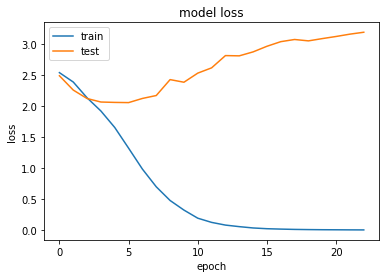

In [14]:
plot_loss()

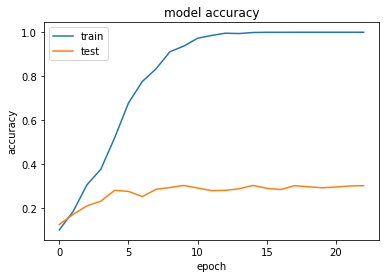

In [15]:
plot_acc()